In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

plt.rcParams["figure.figsize"] = (12, 6)
sns.set_style("whitegrid")

In [2]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_demographic_0_500000.csv to api_data_aadhar_demographic_0_500000.csv
Saving api_data_aadhar_demographic_500000_1000000.csv to api_data_aadhar_demographic_500000_1000000.csv
Saving api_data_aadhar_demographic_1000000_1500000.csv to api_data_aadhar_demographic_1000000_1500000.csv
Saving api_data_aadhar_demographic_1500000_2000000.csv to api_data_aadhar_demographic_1500000_2000000.csv
Saving api_data_aadhar_demographic_2000000_2071700.csv to api_data_aadhar_demographic_2000000_2071700.csv


In [3]:
files_list = [
    "api_data_aadhar_demographic_0_500000.csv",
    "api_data_aadhar_demographic_500000_1000000.csv",
    "api_data_aadhar_demographic_1000000_1500000.csv",
    "api_data_aadhar_demographic_1500000_2000000.csv",
    "api_data_aadhar_demographic_2000000_2071700.csv"
]

combined_df = pd.concat(
    [pd.read_csv(file) for file in files_list],
    ignore_index=True
)

print("Combined Data Shape:", combined_df.shape)
print("Columns:", combined_df.columns.tolist())
combined_df.head()

Combined Data Shape: (2071700, 6)
Columns: ['date', 'state', 'district', 'pincode', 'demo_age_5_17', 'demo_age_17_']


,date,state,district,pincode,demo_age_5_17,demo_age_17_
0,01-03-2025,Uttar Pradesh,Gorakhpur,273213,49,529
1,01-03-2025,Andhra Pradesh,Chittoor,517132,22,375
2,01-03-2025,Gujarat,Rajkot,360006,65,765
3,01-03-2025,Andhra Pradesh,Srikakulam,532484,24,314
4,01-03-2025,Rajasthan,Udaipur,313801,45,785


In [4]:
combined_df["date"] = pd.to_datetime(
    combined_df["date"],
    dayfirst=True,
    errors="coerce"
)

print("Date parsing completed")
print("Null dates:", combined_df["date"].isna().sum())


Date parsing completed
Null dates: 0


In [5]:
combined_df["total_youth"] = (
    combined_df["demo_age_5_17"] +
    combined_df["demo_age_17_"]
)

combined_df["total_population"] = combined_df.filter(
    regex="demo_age"
).sum(axis=1)

print("Youth and population features created")
combined_df[["total_youth", "total_population"]].describe()


Youth and population features created


,total_youth,total_population
count,2.071700e+06,2.071700e+06
mean,2.379456e+01,2.379456e+01
std,1.381999e+02,1.381999e+02
min,0.000000e+00,0.000000e+00
25%,3.000000e+00,3.000000e+00
50%,7.000000e+00,7.000000e+00
75%,1.700000e+01,1.700000e+01
max,1.694200e+04,1.694200e+04


In [6]:
combined_df["year_month"] = combined_df["date"].dt.to_period("M")

monthly_youth = (
    combined_df
    .groupby("year_month")["total_youth"]
    .sum()
    .reset_index()
)

monthly_youth["year_month"] = monthly_youth["year_month"].astype(str)
monthly_youth["mom_growth"] = monthly_youth["total_youth"].pct_change() * 100
monthly_youth["rolling_3m"] = monthly_youth["total_youth"].rolling(3).mean()

print("Monthly aggregation complete")
monthly_youth.head()

Monthly aggregation complete


,year_month,total_youth,mom_growth,rolling_3m
0,2025-03,11147558,NaN,NaN
1,2025-04,1515672,-86.403551,NaN
2,2025-05,1566287,3.339443,4.743172e+06
3,2025-06,1685562,7.615143,1.589174e+06
4,2025-07,2220715,31.749233,1.824188e+06


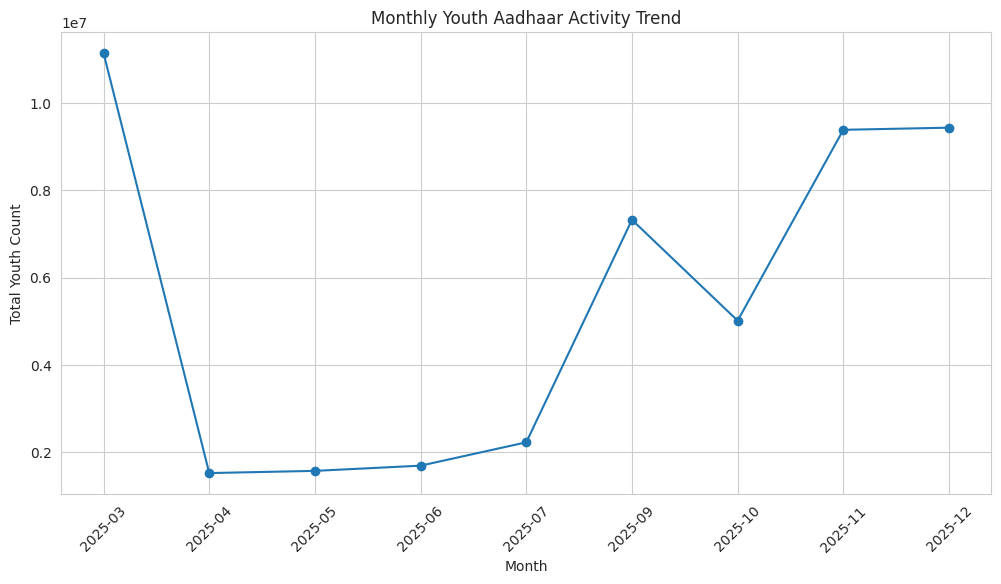

In [7]:
plt.plot(
    monthly_youth["year_month"],
    monthly_youth["total_youth"],
    marker="o"
)
plt.title("Monthly Youth Aadhaar Activity Trend")
plt.xlabel("Month")
plt.ylabel("Total Youth Count")
plt.xticks(rotation=45)
plt.show()


In [8]:
top_states_youth = (
    combined_df
    .groupby("state")["total_youth"]
    .sum()
    .sort_values(ascending=False)
    .head(10)
)

print("Top 10 States by Youth Aadhaar Activity:")
print(top_states_youth)


Top 10 States by Youth Aadhaar Activity:
state
Uttar Pradesh     8542328
Maharashtra       5054602
Bihar             4814350
West Bengal       3872172
Madhya Pradesh    2912938
Rajasthan         2817615
Andhra Pradesh    2295505
Tamil Nadu        2212228
Chhattisgarh      2005434
Gujarat           1824327
Name: total_youth, dtype: int64


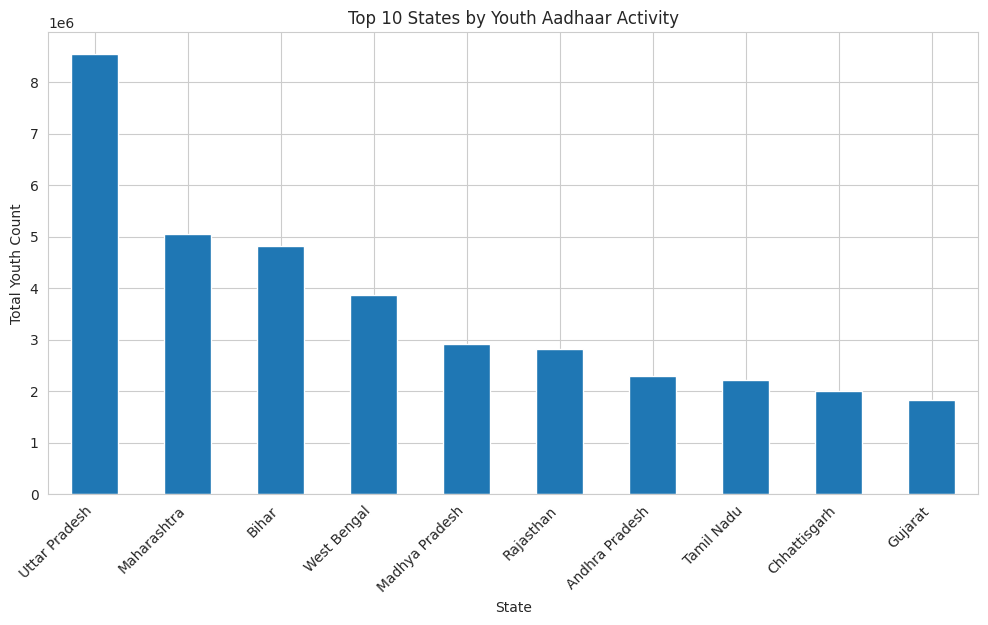

In [9]:
top_states_youth.plot(kind="bar")
plt.title("Top 10 States by Youth Aadhaar Activity")
plt.xlabel("State")
plt.ylabel("Total Youth Count")
plt.xticks(rotation=45, ha="right")
plt.show()

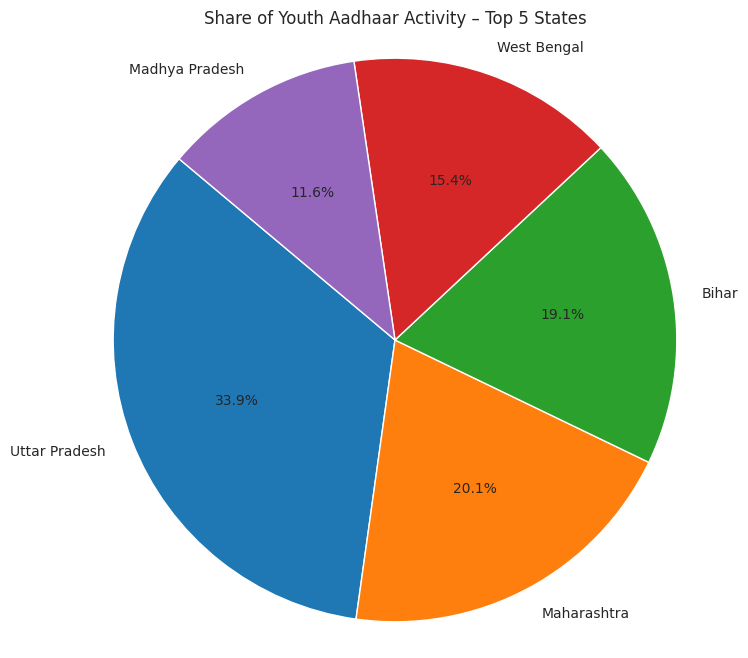

In [10]:
top5_states = top_states_youth.head(5)

plt.figure(figsize=(8, 8))
plt.pie(
    top5_states.values,
    labels=top5_states.index,
    autopct="%1.1f%%",
    startangle=140
)
plt.title("Share of Youth Aadhaar Activity – Top 5 States")
plt.axis("equal")
plt.show()


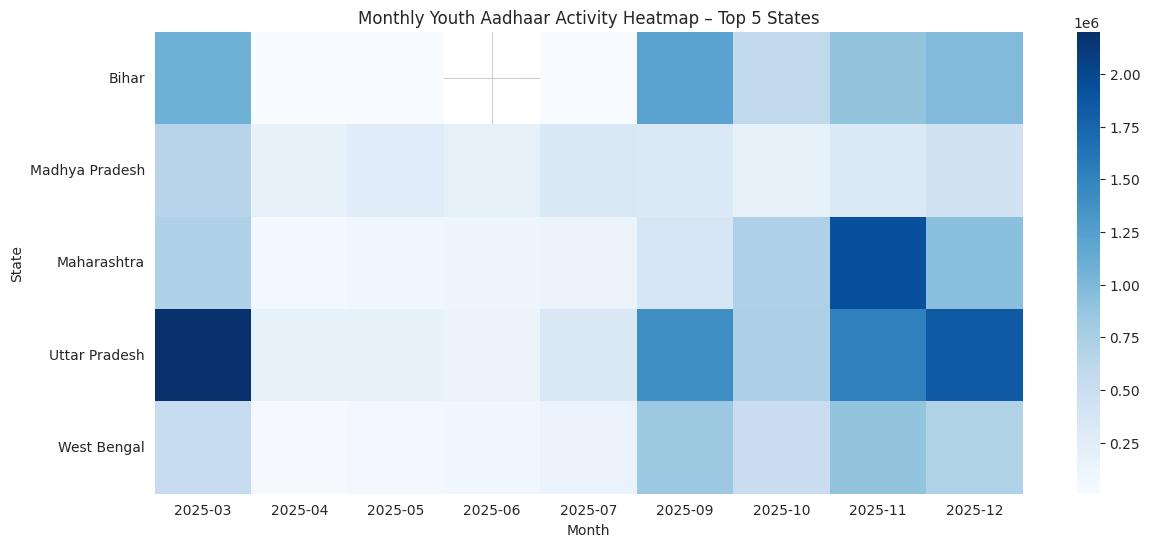

In [11]:
state_monthly = (
    combined_df[combined_df["state"].isin(top5_states.index)]
    .groupby(["state", "year_month"])["total_youth"]
    .sum()
    .unstack()
)

state_monthly.columns = state_monthly.columns.astype(str)

plt.figure(figsize=(14, 6))
sns.heatmap(state_monthly, cmap="Blues")
plt.title("Monthly Youth Aadhaar Activity Heatmap – Top 5 States")
plt.xlabel("Month")
plt.ylabel("State")
plt.show()


In [12]:
combined_df = combined_df.sort_values(["state", "date"])

combined_df["youth_lag_1m"] = (
    combined_df.groupby("state")["total_youth"].shift(1)
)

combined_df["youth_lag_3m"] = (
    combined_df.groupby("state")["total_youth"].shift(3)
)

combined_df["youth_growth_rate"] = (
    (combined_df["total_youth"] - combined_df["youth_lag_1m"]) /
    combined_df["youth_lag_1m"]
)

combined_df["youth_volatility_3m"] = (
    combined_df
    .groupby("state")["total_youth"]
    .rolling(3)
    .std()
    .reset_index(level=0, drop=True)
)

combined_df["youth_population_ratio"] = (
    combined_df["total_youth"] /
    combined_df["total_population"]
)

combined_df.replace([np.inf, -np.inf], np.nan, inplace=True)

print("Lag, growth, volatility features created")
combined_df[[
    "youth_growth_rate",
    "youth_volatility_3m",
    "youth_population_ratio"
]].describe()


Lag, growth, volatility features created


,youth_growth_rate,youth_volatility_3m,youth_population_ratio
count,2.069496e+06,2.071573e+06,2069561.0
mean,1.749875e+00,1.712128e+01,1.0
std,8.032097e+00,8.774805e+01,0.0
min,-1.000000e+00,0.000000e+00,1.0
25%,-5.714286e-01,2.309401e+00,1.0
50%,0.000000e+00,5.567764e+00,1.0
75%,1.333333e+00,1.357694e+01,1.0
max,9.480000e+02,8.848072e+03,1.0


In [13]:
ml_df = combined_df[[
    "state",
    "total_youth",
    "youth_growth_rate",
    "youth_volatility_3m",
    "youth_population_ratio"
]].dropna()

state_ml = ml_df.groupby("state").mean()

print("ML dataset shape:", state_ml.shape)
state_ml.head()


ML dataset shape: (57, 4)


,total_youth,youth_growth_rate,youth_volatility_3m,youth_population_ratio
state,,,,
Andaman & Nicobar Islands,2.068493,0.440255,1.165224,1.0
Andaman and Nicobar Islands,4.789082,0.968186,3.235039,1.0
Andhra Pradesh,11.109116,0.991649,7.212278,1.0
Arunachal Pradesh,7.688903,1.388484,5.641745,1.0
Assam,16.117230,1.723547,12.027467,1.0


In [14]:
scaler = StandardScaler()
X = scaler.fit_transform(state_ml)

kmeans = KMeans(n_clusters=3, random_state=42)
state_ml["cluster"] = kmeans.fit_predict(X)

print("Clustering complete")
state_ml.sort_values("cluster").head()


Clustering complete


,total_youth,youth_growth_rate,youth_volatility_3m,youth_population_ratio,cluster
state,,,,,
Chandigarh,40.898915,2.303472,29.807643,1.0,0
Bihar,49.311436,2.936232,34.548776,1.0,0
Dadra and Nagar Haveli,14.953560,2.397162,15.250459,1.0,0
Chhattisgarh,56.146751,3.210548,41.989865,1.0,0
Maharashtra,31.173788,2.308029,24.050645,1.0,0


In [15]:
cluster_summary = (
    state_ml
    .groupby("cluster")
    .agg({
        "total_youth": "mean",
        "youth_growth_rate": "mean",
        "youth_volatility_3m": "mean",
        "youth_population_ratio": "mean"
    })
)

print("\nCluster-wise Average Characteristics:")
print(cluster_summary)



Cluster-wise Average Characteristics:
         total_youth  youth_growth_rate  youth_volatility_3m  \
cluster                                                        
0          36.422815           2.703058            28.272263   
1           6.563116           0.776915             4.445770   
2         136.270897           2.965052            97.805317   

         youth_population_ratio  
cluster                          
0                           1.0  
1                           1.0  
2                           1.0  


In [16]:
for cluster_id in sorted(state_ml["cluster"].unique()):
    print(f"\nCluster {cluster_id} States:")
    print(
        state_ml[state_ml["cluster"] == cluster_id]
        .index
        .tolist()
    )


Cluster 0 States:
['Bihar', 'Chandigarh', 'Chhattisgarh', 'Dadra and Nagar Haveli', 'Haryana', 'Jharkhand', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Rajasthan', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal']

Cluster 1 States:
['Andaman & Nicobar Islands', 'Andaman and Nicobar Islands', 'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Chhatisgarh', 'Dadra & Nagar Haveli', 'Dadra and Nagar Haveli and Daman and Diu', 'Daman & Diu', 'Daman and Diu', 'Goa', 'Gujarat', 'Himachal Pradesh', 'Jammu & Kashmir', 'Jammu and Kashmir', 'Karnataka', 'Kerala', 'Ladakh', 'Lakshadweep', 'Meghalaya', 'Mizoram', 'Nagaland', 'ODISHA', 'Odisha', 'Orissa', 'Pondicherry', 'Puducherry', 'Punjab', 'Sikkim', 'Tamil Nadu', 'Telangana', 'Tripura', 'Uttaranchal', 'WEST BENGAL', 'WESTBENGAL', 'West  Bengal', 'West Bangal', 'West Bengli', 'West bengal', 'Westbengal', 'andhra pradesh', 'odisha', 'west Bengal']

Cluster 2 States:
['Delhi']
